In [1]:
import fastai
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import DDGS
from utils import *

Analysing which label is giving correct data 

In [2]:
urls=DDGS().images('human fear face',max_results=1) #Search
links=L(urls).itemgot('image') #Get Link

In [3]:
image_dest='sample_face.jpg'
download_url(links[0],image_dest, show_progress=False) #Download using download_url 

Path('sample_face.jpg')

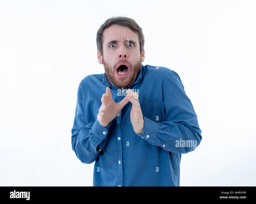

In [5]:
im=Image.open(image_dest)
im.to_thumb(256,256) #Open

Going ahead with "Human <emotion> face"

In [6]:
#Defining Search Function (for search and getting link)
def search_images(label,max_images=40):
    urls=DDGS().images(label,max_results=max_images)
    links=L(urls).itemgot('image')
    return links

In [7]:
#Doing the needy
searches='happy','sad','fear','disgust','angry','surprise'
path=Path('emotions')
from time import sleep #To prevent the server from getting overloaded

for each_emotion in searches:
    dest=(path/each_emotion)
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest,urls=search_images(f'human {each_emotion} face'))
    sleep(20)
    download_images(dest,urls=search_images(f'human {each_emotion} face'))
    sleep(20)
    download_images(dest,urls=search_images(f'human {each_emotion} face'))
    resize_image(path/each_emotion, max_size=500, dest=path/each_emotion)
    
    

Images Verification

In [20]:
#Getting Failed images and removing them simulataneously
for each_em in searches:
    failed=verify_images((path/each_em).ls())
    print(f'Failed images for {each_em} emotion are {len(failed)}')
    failed.map(Path.unlink)
    

Failed images for happy emotion are 0
Failed images for sad emotion are 0
Failed images for fear emotion are 0
Failed images for disgust emotion are 0
Failed images for angry emotion are 0
Failed images for surprise emotion are 0


Done with the verification!

Training our model now

In [30]:
#Determining out datablocks (template for dataloaders) and loading the dataloaders
dls=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.4,seed=50),
    get_y=parent_label,
    item_tfms=[Resize(192,method='squish')]
)
dls=dls.dataloaders(path,bs=16) #lower batch size as I dont want to heat up my laptop

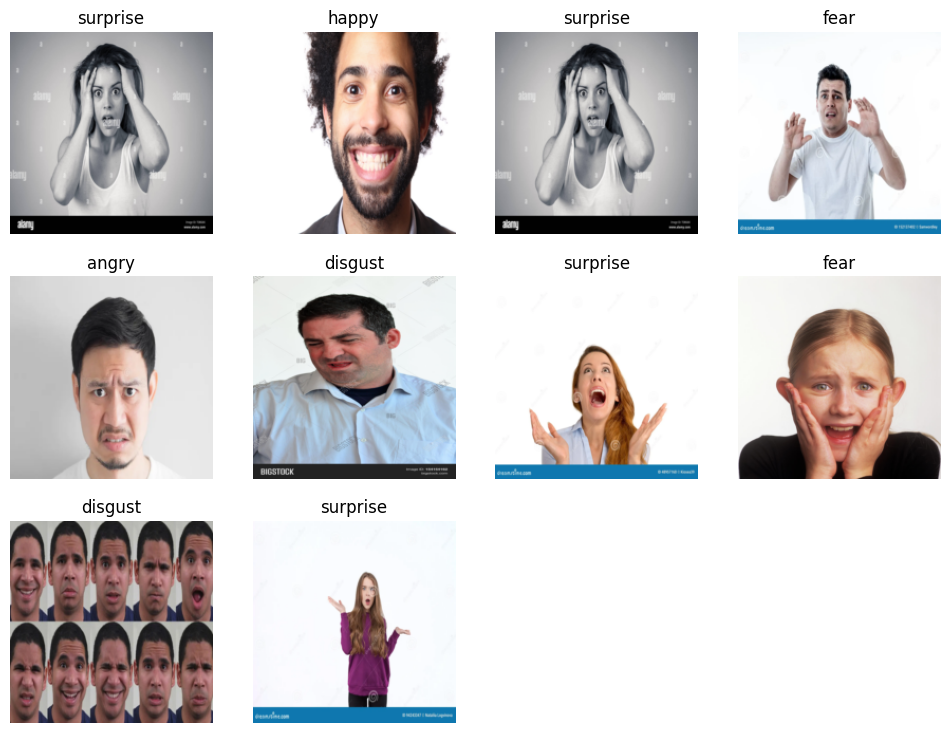

In [31]:
dls.show_batch(max_n=10)

In [34]:
#Fine-tuning pre_trained model
model=vision_learner(dls,resnet18,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mohit/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:10<00:00, 4.57MB/s]


In [35]:
model.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.363007,1.045494,0.362595,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.031020,0.479970,0.133588,00:53
1,0.630353,0.367930,0.091603,00:54
2,0.375652,0.350443,0.103053,00:53


Trying out our model, YAYYY!

In [45]:
emotion,_,probs=model.predict(PILImage.create('sample_face.jpg'))

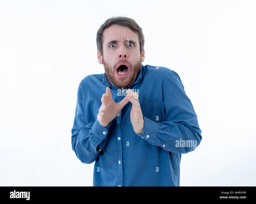

In [46]:
#Output
Image.open('sample_face.jpg').to_thumb(256,256)

In [52]:
print(f'The emotion is {emotion} with probability being {probs[0]:.4f}')

The emotion is fear with probability being 0.0004


In [54]:
#Another sample
sample='sample_face2.jpg'
download_url(search_images('human angry face',max_images=1)[0],sample,show_progress=False)

Path('sample_face2.jpg')

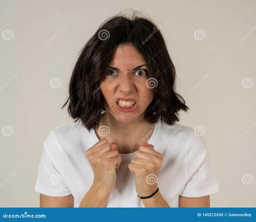

In [55]:
emotion,_,probs=model.predict(PILImage.create('sample_face2.jpg'))